In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [6]:
X, y = mnist["data"], mnist["target"]


Saving figure some_digit_plot


FileNotFoundError: [Errno 2] No such file or directory: './images/classification/some_digit_plot.png'

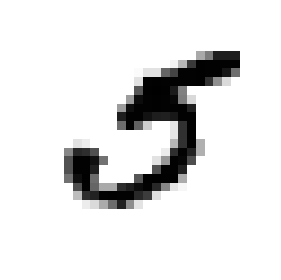

In [57]:
some_digit = X[36000]

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [ ]:
# Train Classifier 

In [30]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [31]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [72]:
y_train_even = (y_train %2 == 0)
y_test_even = (y_test %2 == 0)

In [73]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_even)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:
# Test Classifier with some digits
zero = X[5000]
one = X[11000]
two = X[18000]
three = X[20000]
four = X[26000]
five = X[36000]
six = X[40000]
seven = X[43000]
eight = X[49100]
nine = X[55000]

digits_that_are_even = [zero, two, four, six, eight]
digits_that_are_odd = [one, three, five, seven, nine]

In [75]:
sgd_clf.predict(digits_that_are_even) # There are some false positive here 

array([ True,  True, False,  True, False])

In [76]:
sgd_clf.predict(digits_that_are_odd) # Looks like it was able to accurately predict that it is not even

array([False, False, False, False, False])

In [78]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_even, cv=3, scoring="accuracy")

array([0.85785711, 0.7514    , 0.8679934 ])

In [80]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_even):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_even[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_even[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8578571071446428
0.7514
0.8679933996699835


In [83]:
from sklearn.base import BaseEstimator
class NeverEvenClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [84]:
never_5_clf = NeverEvenClassifier()
cross_val_score(never_5_clf, X_train, y_train_even, cv=3, scoring="accuracy")

array([0.5048, 0.5104, 0.5102])

In [85]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_even, cv=3)

In [86]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_even, y_train_pred)

array([[22296,  8212],
       [ 2243, 27249]])

In [87]:
y_train_perfect_predictions = y_train_even


In [89]:
confusion_matrix(y_train_even, y_train_perfect_predictions)


array([[30508,     0],
       [    0, 29492]])

In [90]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_even, y_train_pred)

0.7684216463156708

In [91]:
recall_score(y_train_even, y_train_pred)

0.9239454767394548

In [92]:
from sklearn.metrics import f1_score
f1_score(y_train_even, y_train_pred)

0.8390374578541407

In [93]:
# Now with KNN Classifier

In [95]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train_even)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [102]:
# Test classifier with even digits
knn_clf.predict(digits_that_are_even) #Looks like there are no false positives

array([ True,  True,  True,  True,  True])

In [103]:
knn_clf.predict(digits_that_are_odd) # No false negatives here 

array([False, False, False, False, False])

In [ ]:
# Lets Compare the Accuracy of both 

In [96]:
y_knn_pred = knn_clf.predict(X_test)



In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_even, y_knn_pred) # Accuracy of KNN

0.986

In [105]:
y_bin_pred = sgd_clf.predict(X_test)

In [107]:
accuracy_score(y_test_even, y_bin_pred) # Accuracy of SGD

0.7647